<a href="https://colab.research.google.com/github/kyokicchi/ggl_an_codes/blob/master/NNmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# initialize & load

In [1]:
from google.colab import drive
from google.colab import files

import numpy as np
import pandas as pd

from keras import models
from keras import layers
from keras.models import load_model

Using TensorFlow backend.


In [2]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
%cd ../content/gdrive/My Drive/projects/ggl_an/
%ls

/content/gdrive/My Drive/projects/ggl_an
model_LGB.sav  output_LGB.csv  user_test.csv    user_train.csv
model_NN.h5    output_NN.csv   user_test_n.csv  user_train_n.csv


In [5]:
%%time
filename = 'model_NN.h5'
model = load_model(filename)

df_train = pd.read_csv('user_train_n.csv', index_col = 0)
df_test = pd.read_csv('user_test_n.csv', index_col = 0)

df_y = df_train['transactionRevenue']
df_x = df_train.drop(['transactionRevenue'], axis=1)
df_tgt = df_test.drop(['transactionRevenue'], axis=1)

<string>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 8.7 s, sys: 867 ms, total: 9.57 s
Wall time: 13.4 s


In [6]:
print(df_x.shape, df_y.shape, df_tgt.shape)

(714167, 23) (714167,) (617242, 23)


# train model

In [0]:
from keras import optimizers


def build_model(N_col):
  rate = 0.001
  model = models.Sequential()
  model.add(layers.Dense(N_col * 4, activation='relu', input_shape=(N_col,)))
  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(200, activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.Dense(50, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer=optimizers.adam(lr = rate), loss='mse', metrics=['mae'])
  return model

In [74]:
%%time
#epochs = 100
epochs = 500
batch_size = df_x.shape[0] // 4
validation_split = 0.1

model = build_model(df_x.shape[1])

history = model.fit(df_x,
                    df_y,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split = validation_split,
                    verbose=1)

Train on 642750 samples, validate on 71417 samples
Epoch 1/500
642750/642750 [==============================] - 3s 4us/step - loss: 8.4498 - mean_absolute_error: 0.3641 - val_loss: 8.5484 - val_mean_absolute_error: 0.4877
Epoch 2/500
642750/642750 [==============================] - 1s 2us/step - loss: 8.3628 - mean_absolute_error: 0.5669 - val_loss: 8.5225 - val_mean_absolute_error: 0.6214
Epoch 3/500
642750/642750 [==============================] - 1s 2us/step - loss: 8.3346 - mean_absolute_error: 0.6062 - val_loss: 8.4744 - val_mean_absolute_error: 0.5283
Epoch 4/500
642750/642750 [==============================] - 1s 2us/step - loss: 8.2797 - mean_absolute_error: 0.5323 - val_loss: 8.3940 - val_mean_absolute_error: 0.5422
Epoch 5/500
642750/642750 [==============================] - 1s 2us/step - loss: 8.1988 - mean_absolute_error: 0.5677 - val_loss: 8.2899 - val_mean_absolute_error: 0.5196
Epoch 6/500
642750/642750 [==============================] - 1s 2us/step - loss: 8.0932 - mean

# evaluate model

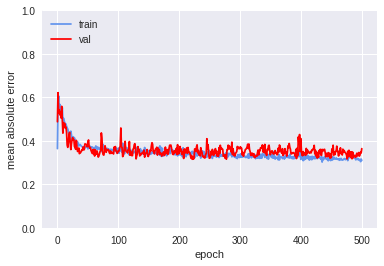

In [75]:
#dir(history)
#history.history

x = history.epoch
y = history.history['mean_absolute_error']
z = history.history['val_mean_absolute_error']

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x, y, color='cornflowerblue', label = 'train')
plt.plot(x, z, color='red', label = 'val')
plt.legend(loc="upper left")
plt.ylim(0, 1)
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('mean absolute error')
plt.show()

In [76]:
%%time

from sklearn.metrics import mean_squared_error

pred = model.predict(df_x)
mse = mean_squared_error(df_y, pred)
rmse = np.sqrt(mse)
print(rmse)

1.8298523021188284
CPU times: user 38.3 s, sys: 3.78 s, total: 42.1 s
Wall time: 33.7 s


2.048579998484373

2.08106061338436

2.894300942225228

2.122997035400416

2.07703580318282

2.158526362017965

2.1637144539984035

1.8298523021188284

In [77]:
%%time
model.save(filename)

#files.download(filename)

CPU times: user 1.64 s, sys: 20.1 ms, total: 1.66 s
Wall time: 1.68 s


# predict & output

In [78]:
%%time
pred_tgt = model.predict(df_tgt)


CPU times: user 32.7 s, sys: 3.41 s, total: 36.1 s
Wall time: 28.8 s


In [79]:
%%time

pred_tgt[pred_tgt<0] = 0
df_out = pd.DataFrame(index = df_tgt.index)
df_out['PredictedLogRevenue'] = pred_tgt

df_out.to_csv('output_NN.csv')

CPU times: user 1.24 s, sys: 18.9 ms, total: 1.26 s
Wall time: 1.35 s


In [80]:
pred_tgt.shape, pred_tgt.max(), pred_tgt.min(), len(pred_tgt[pred_tgt>=0.1])/len(pred_tgt)

((617242, 1), 240.09981, 0.0, 0.09404091102031294)

In [81]:
df_out.head()

,PredictedLogRevenue
fullVisitorId,
259678714014,1.090844
49363351866189,0.019905
53049821714864,0.021847
59488412965267,0.022038
85840370633780,0.008995


In [82]:
df_out.describe()

,PredictedLogRevenue
count,617242.000000
mean,0.221397
std,1.434980
min,0.000000
25%,0.010868
50%,0.015476
75%,0.025620
max,240.099808
